In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import librosa as lb
from librosa import display

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
train=np.load("gdrive/My Drive/audio-classification/audio_train.npy")
test=np.load("gdrive/My Drive/audio-classification/audio_test.npy")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train.shape

(942, 30000)

In [ ]:
print(train)

[[-0.92577249 -0.66291571 -0.26374164 ...  0.          0.
   0.        ]
 [ 0.94556701  1.11562371  1.10488427 ...  0.          0.
   0.        ]
 [-0.01025403 -0.01226821 -0.01267925 ...  0.          0.
   0.        ]
 ...
 [ 1.00239253  1.10180998  1.03759027 ...  0.          0.
   0.        ]
 [-0.00936416 -0.01141811 -0.01222591 ...  0.          0.
   0.        ]
 [-0.87232733 -0.1913518   0.57717735 ...  0.          0.
   0.        ]]


In [ ]:
train_labels=pd.read_csv("gdrive/My Drive/audio-classification/labels_train.csv",usecols=['label']).to_numpy()

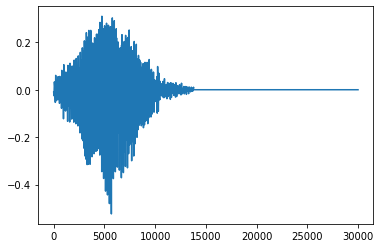

In [ ]:
plt.plot(train[2])

# Converting 1 D Data to 2 D Spectograms

In [ ]:
train_spectograms = []
for i in range(train.shape[0]):
    spectogram = lb.stft(train[i])
    Xdb = lb.amplitude_to_db(abs(spectogram))
    train_spectograms.append(Xdb)

In [ ]:
train_spectograms = np.array(train_spectograms)

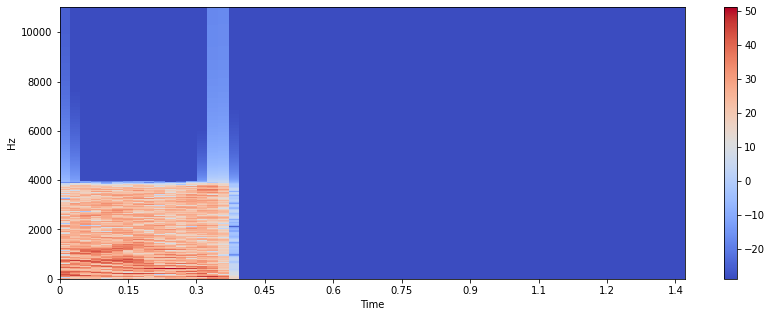

In [ ]:
plt.figure(figsize=(14, 5))
lb.display.specshow(train_spectograms[0], x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
print(train_spectograms.shape)

(942, 1025, 59)


In [ ]:
from PIL import Image

In [ ]:
x_train = []
for i in range(train_spectograms.shape[0]):
  foo = Image.fromarray(train_spectograms[i])
  x = train_spectograms[i].shape[0] // 3
  y = train_spectograms[i].shape[1] // 3
  foo = foo.resize((y, x), Image.ANTIALIAS)
  np_im = np.array(foo)
  x_train.append(np_im)

In [ ]:
x_train = np.array(x_train)

In [ ]:
print(x_train)

[[[ 31.417025    28.157215    30.776808   ... -28.822094   -28.822094
   -28.822094  ]
  [ 25.079102    20.530851    23.147469   ... -28.822094   -28.822094
   -28.822094  ]
  [ 16.967445    20.568254    20.620193   ... -28.822094   -28.822094
   -28.822094  ]
  ...
  [-27.855667   -28.984114   -28.598423   ... -28.822094   -28.822094
   -28.822094  ]
  [-27.855808   -28.98409    -28.598438   ... -28.822094   -28.822094
   -28.822094  ]
  [-27.85622    -28.984022   -28.59846    ... -28.822094   -28.822094
   -28.822094  ]]

 [[ 31.484844    30.89782     35.648853   ... -25.65062    -25.65062
   -25.65062   ]
  [ 25.645658    23.4414      24.09149    ... -25.65062    -25.65062
   -25.65062   ]
  [ 23.611818    19.406494    23.869724   ... -25.65062    -25.65062
   -25.65062   ]
  ...
  [-22.595837   -25.991423   -25.92952    ... -25.65062    -25.65062
   -25.65062   ]
  [-22.596004   -25.991411   -25.929504   ... -25.65062    -25.65062
   -25.65062   ]
  [-22.596382   -25.991383   -25.9

In [ ]:
x_train = x_train / 255.

In [ ]:
print(x_train[0].shape)

(341, 19)


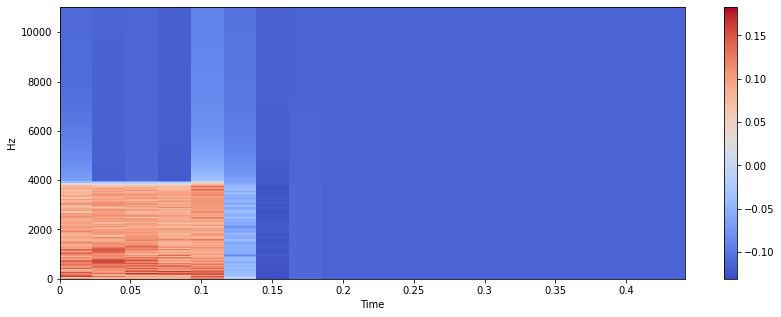

In [ ]:
plt.figure(figsize=(14, 5))
lb.display.specshow(x_train[0], x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)

In [ ]:
print(x_train.shape)

(942, 341, 19, 1)


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
original_dim = (341, 19, 1)
latent_dim = 2
original_dim_other = 6479
intermediate_dim = 300

In [ ]:
original_inputs = tf.keras.Input(shape=x_train[0].shape, name="encoder_input")
print(original_inputs.shape)
x = layers.Conv2D(32, (2, 2),activation='relu')(original_inputs)
print(x.shape)
y = layers.Conv2D(32, (2, 2),activation='relu')(x)
print(y.shape)
z = layers.Flatten()(y)
print(z.shape)
p = layers.Dense(intermediate_dim, activation="relu")(z)
print(p.shape)
z_mean = layers.Dense(latent_dim, name="z_mean")(p)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(p)
z_samples = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z_samples, name="encoder")
print(z_samples.shape)

(None, 341, 19, 1)
(None, 340, 18, 32)
(None, 339, 17, 32)
(None, 184416)
(None, 300)
(None, 2)


In [ ]:
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
print(latent_inputs.shape)
x1 = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
print(x1.shape)
y1 = layers.Dense(339*17*32, activation="relu")(x1)
print(y1.shape)
z1 = layers.Reshape(target_shape=(339, 17, 32))(y1)
print(z1.shape)
p1 = layers.Conv2DTranspose(filters=32, kernel_size=(2,2),activation='relu')(z1)
print(p1.shape)
q1 = layers.Conv2DTranspose(filters=32, kernel_size=(2,2), activation='relu')(p1)
print(q1.shape)
outs = layers.Conv2DTranspose(filters=1, kernel_size=(2,2), padding='same', activation='relu')(q1)
print(outs.shape)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outs, name="decoder")

(None, 2)
(None, 300)
(None, 184416)
(None, 339, 17, 32)
(None, 340, 18, 32)
(None, 341, 19, 32)
(None, 341, 19, 1)


In [ ]:
outputs = decoder(z_samples)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
reconstruction_loss = binary_crossentropy(original_inputs,outputs)
reconstruction_loss *= original_dim_other
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [ ]:
epoch_num=20
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=epoch_num, batch_size=128)

Epoch 1/20
8/8 [==============================] - 31s 4s/step - loss: -15484.7188
Epoch 2/20
8/8 [==============================] - 31s 4s/step - loss: -15864.7725
Epoch 3/20
8/8 [==============================] - 31s 4s/step - loss: -15874.8926
Epoch 4/20
8/8 [==============================] - 31s 4s/step - loss: -15877.1465
Epoch 5/20
8/8 [==============================] - 33s 4s/step - loss: -15877.4912
Epoch 6/20
8/8 [==============================] - 31s 4s/step - loss: -15878.2578
Epoch 7/20
8/8 [==============================] - 31s 4s/step - loss: -15878.6123
Epoch 8/20
8/8 [==============================] - 31s 4s/step - loss: -15879.1211
Epoch 9/20
8/8 [==============================] - 31s 4s/step - loss: -15879.5859
Epoch 10/20
8/8 [==============================] - 31s 4s/step - loss: -15879.6729
Epoch 11/20
8/8 [==============================] - 31s 4s/step - loss: -15879.5068
Epoch 12/20
8/8 [==============================] - 31s 4s/step - loss: -15879.2402
Epoch 13/20
8

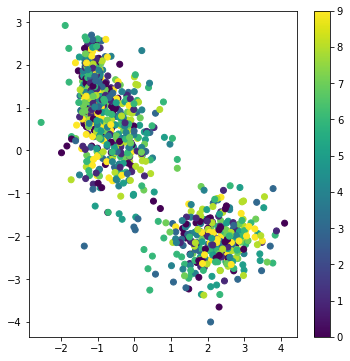

In [ ]:
import matplotlib.pyplot as plt

x_train_encoded = encoder.predict(x_train, batch_size=64)
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=train_labels)
plt.colorbar()
plt.show()

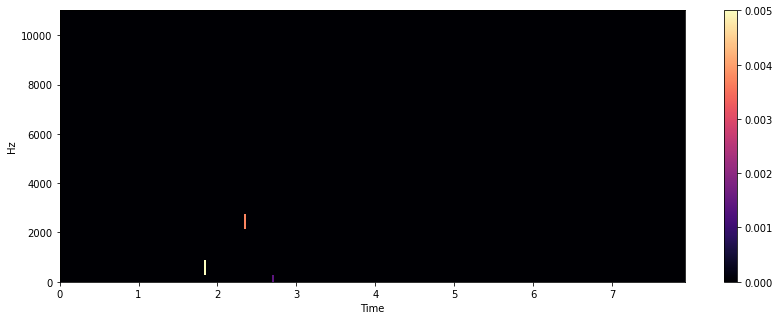

In [ ]:
h_size = 19
w_size = 341
figure = np.zeros((h_size, w_size))
import random

xi = []
for i in range(2):
  x  = random.random()
  xi.append(x)
# xi = random.random()
# yi = random.random()

z_sample = np.array([[xi]]) 
x_decoded = decoder.predict(z_sample)
spec = x_decoded[0].reshape(h_size, w_size)

# plt.figure(figsize=(10, 10))
# plt.imshow(spec)
# plt.show()

plt.figure(figsize=(14, 5))
lb.display.specshow(spec, x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
regr = RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
regr.fit(x_train_encoded,train_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
test

array([[ 9.64330852e-01,  1.11710596e+00,  1.09370148e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.52466893e-01,  1.59739897e-01,  6.83851719e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.06442046e-01, -1.02794206e+00, -1.05598438e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.38109326e-02, -1.99792925e-02, -2.55593378e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.29138488e-04, -1.70684914e-04,  2.37883345e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.21651900e-01,  9.79262292e-01,  1.00515318e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
print(test.shape)

(558, 30000)


In [ ]:
test_spectograms = []
for i in range(test.shape[0]):
    spectogram = lb.stft(test[i])
    Xdb = lb.amplitude_to_db(abs(spectogram))
    test_spectograms.append(Xdb)

In [ ]:
test_spectograms = np.array(test_spectograms)

In [ ]:
test_spectograms.shape

(558, 1025, 59)

In [ ]:
x_test = []
for i in range(test_spectograms.shape[0]):
  foo = Image.fromarray(test_spectograms[i])
  x = test_spectograms[i].shape[0] // 3
  y = test_spectograms[i].shape[1] // 3
  foo = foo.resize((y, x), Image.ANTIALIAS)
  np_im = np.array(foo)
  x_test.append(np_im)

In [ ]:
x_test = np.array(x_test)

In [ ]:
x_test.shape

(558, 341, 19)

In [ ]:
x_test = x_test / 255.

In [ ]:
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

In [ ]:
x_test.shape

(558, 341, 19, 1)

In [ ]:
encoded_test = encoder.predict(x_test, batch_size=64)

In [ ]:
encoded_test.shape

(558, 2)

In [ ]:
predicted = regr.predict(encoded_test)

In [ ]:
predicted

array([6, 8, 6, 8, 8, 8, 6, 0, 0, 5, 8, 0, 8, 9, 9, 9, 8, 8, 1, 0, 8, 0,
       0, 0, 0, 0, 8, 6, 8, 8, 0, 6, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 6,
       0, 6, 6, 9, 6, 0, 0, 0, 8, 5, 8, 8, 0, 0, 0, 0, 0, 9, 6, 9, 8, 5,
       8, 0, 9, 0, 0, 0, 0, 8, 8, 6, 0, 0, 8, 8, 0, 6, 6, 0, 0, 8, 0, 0,
       8, 0, 6, 8, 8, 0, 9, 0, 5, 3, 0, 0, 0, 0, 8, 0, 5, 8, 0, 0, 0, 0,
       0, 3, 0, 8, 0, 9, 0, 8, 0, 6, 0, 3, 0, 0, 0, 0, 0, 0, 8, 0, 0, 6,
       0, 6, 6, 0, 0, 8, 0, 8, 8, 0, 5, 8, 9, 8, 8, 0, 5, 8, 0, 0, 0, 8,
       6, 8, 9, 0, 8, 0, 6, 3, 0, 0, 3, 0, 0, 6, 0, 6, 6, 0, 8, 5, 0, 6,
       6, 0, 6, 8, 9, 8, 0, 0, 0, 0, 0, 6, 6, 6, 0, 0, 0, 0, 8, 8, 6, 1,
       0, 0, 0, 0, 8, 0, 0, 8, 0, 6, 0, 6, 0, 0, 6, 8, 0, 0, 0, 0, 8, 0,
       0, 0, 6, 0, 0, 5, 5, 0, 8, 0, 0, 0, 0, 6, 0, 6, 0, 0, 8, 3, 0, 8,
       6, 0, 0, 5, 0, 0, 0, 8, 0, 0, 6, 8, 0, 0, 8, 0, 0, 0, 0, 0, 0, 5,
       0, 8, 0, 8, 0, 8, 0, 0, 6, 0, 6, 0, 0, 0, 8, 6, 0, 8, 0, 9, 6, 0,
       0, 0, 8, 5, 0, 0, 0, 3, 0, 0, 0, 8, 6, 6, 0,

In [ ]:
df = pd.DataFrame(data={'ID': range(0,len(test)), 'label': predicted})

In [ ]:
df

,ID,label
0,0,6
1,1,8
2,2,6
3,3,8
4,4,8
...,...,...
553,553,9
554,554,9
555,555,8
556,556,0


In [ ]:
from google.colab import files

df.to_csv('RandomForest.csv', sep=',',  index = False)

files.download('RandomForest.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Q3)  Finally create a random forest classifier for the competition with the 50 dim embeddings as features.   How does the model perform?

Ans: The model does not perform well on the reduced 50 dimensional data. It has well less validation accuracy. 